# Lib Import

In [1]:
import pickle
import pandas                   as pd
import numpy                    as np
from sklearn.metrics            import f1_score, precision_score, recall_score, precision_recall_fscore_support, accuracy_score, roc_auc_score, f1_score
from xgboost                    import plot_importance
from sklearn.model_selection    import train_test_split
from sklearn.feature_selection import SelectFromModel
from xgboost                    import XGBClassifier
from sklearn.preprocessing      import MinMaxScaler, StandardScaler, RobustScaler
from lazypredict.Supervised     import LazyClassifier
from lightgbm                   import LGBMRegressor
from skopt                      import gp_minimize
from sklearn.ensemble           import RandomForestClassifier
from boruta                     import BorutaPy
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import StratifiedKFold
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC
import scikitplot as skplt
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier


# 0.0 Data import/split

In [2]:
df0 = pd.read_csv("../data/base_modelo.csv", index_col="id")
df0.columns = df0.columns.str.lower()
test = df0[df0['safra']>=201407]
df0 = df0[df0['safra']<=201406]
print( df0.shape, test.shape )
df0.head(3)

(5454, 80) (5284, 80)


,safra,y,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78
id,,,,,,,,,,,,,,,,,,,,,
1,201404,0,0.00,0.00,0.00,0.00,124.54,3277.00,51.98,NaN,...,156.38,7.52,0.00,151.00,0.00,3.00,477.84,173.06,0.00,3.00
3,201405,0,99.00,2.00,2.00,2.00,80.38,1824.00,26.63,NaN,...,471.86,NaN,NaN,96.00,NaN,NaN,NaN,732.00,121.98,NaN
5,201403,1,0.00,0.00,0.00,0.00,70.46,437.00,40.69,10.99,...,NaN,NaN,0.00,75.00,0.00,0.00,914.45,NaN,NaN,0.00


In [3]:
print( df0['safra'].unique(),  test['safra'].unique() )

[201404 201405 201403 201401 201402 201406] [201407 201412 201409 201408 201411 201410]


# 1.0 Data Description

## 1.1 data types

In [4]:
df1 = df0.copy()

In [5]:
df1.dtypes.nunique()

2

In [6]:
df1.dtypes

safra       int64
y           int64
var_1     float64
var_2     float64
var_3     float64
           ...   
var_74    float64
var_75    float64
var_76    float64
var_77    float64
var_78    float64
Length: 80, dtype: object

## 1.2 null values

In [7]:
(df1.isnull().sum()/len(df1)).sort_values(ascending=False)

var_62   0.79
var_70   0.78
var_61   0.72
var_49   0.69
var_36   0.69
         ... 
var_60   0.00
var_57   0.00
var_20   0.00
var_32   0.00
safra    0.00
Length: 80, dtype: float64

## 1.3 data dimension

In [8]:
df1.shape

(5454, 80)

# 2.0 FEATURE ENGINEERING

In [9]:
df2 = df1.copy()

# 3.0 FEATURE FILTERING

In [10]:
df3 = df2.copy()

# 4.0 EDA

In [11]:
df4 = df3.copy()

In [12]:
df4['y'].mean()

0.27997799779978

In [13]:
df4['safra'].value_counts().sort_index()

201401    854
201402    898
201403    873
201404    955
201405    972
201406    902
Name: safra, dtype: int64

# 5.0 DATA PREPARATION

## 5.1 Split into target and features

In [14]:
df5 = df4.copy()
Xtrain, ytrain = df5.drop(['y'], axis=1) , df5['y']
Xtest, ytest = test.drop(['y'], axis=1) , test['y']

Xtrain5, Xtest5 = Xtrain.copy(), Xtest.copy()

# 6.0 FEATURE SELECTION

In [15]:
Xtrain6 = Xtrain5.drop(['safra'],axis=1).copy()
Xtest6 = Xtest5.drop(['safra'],axis=1).copy()

In [17]:
xgb = LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1)
xgb.fit( Xtrain6, ytrain )

print( Xtrain6.shape )

model = SelectFromModel( xgb, prefit=True )
Xtrain6 = model.transform( Xtrain6 )
Xtest6 = model.transform( Xtest6 )
print( Xtrain6.shape, Xtest6.shape )

(5454, 78)
(5454, 27) (5284, 27)


# 7.0 ML MODELING

## 7.1 XGBClassifier

<AxesSubplot: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

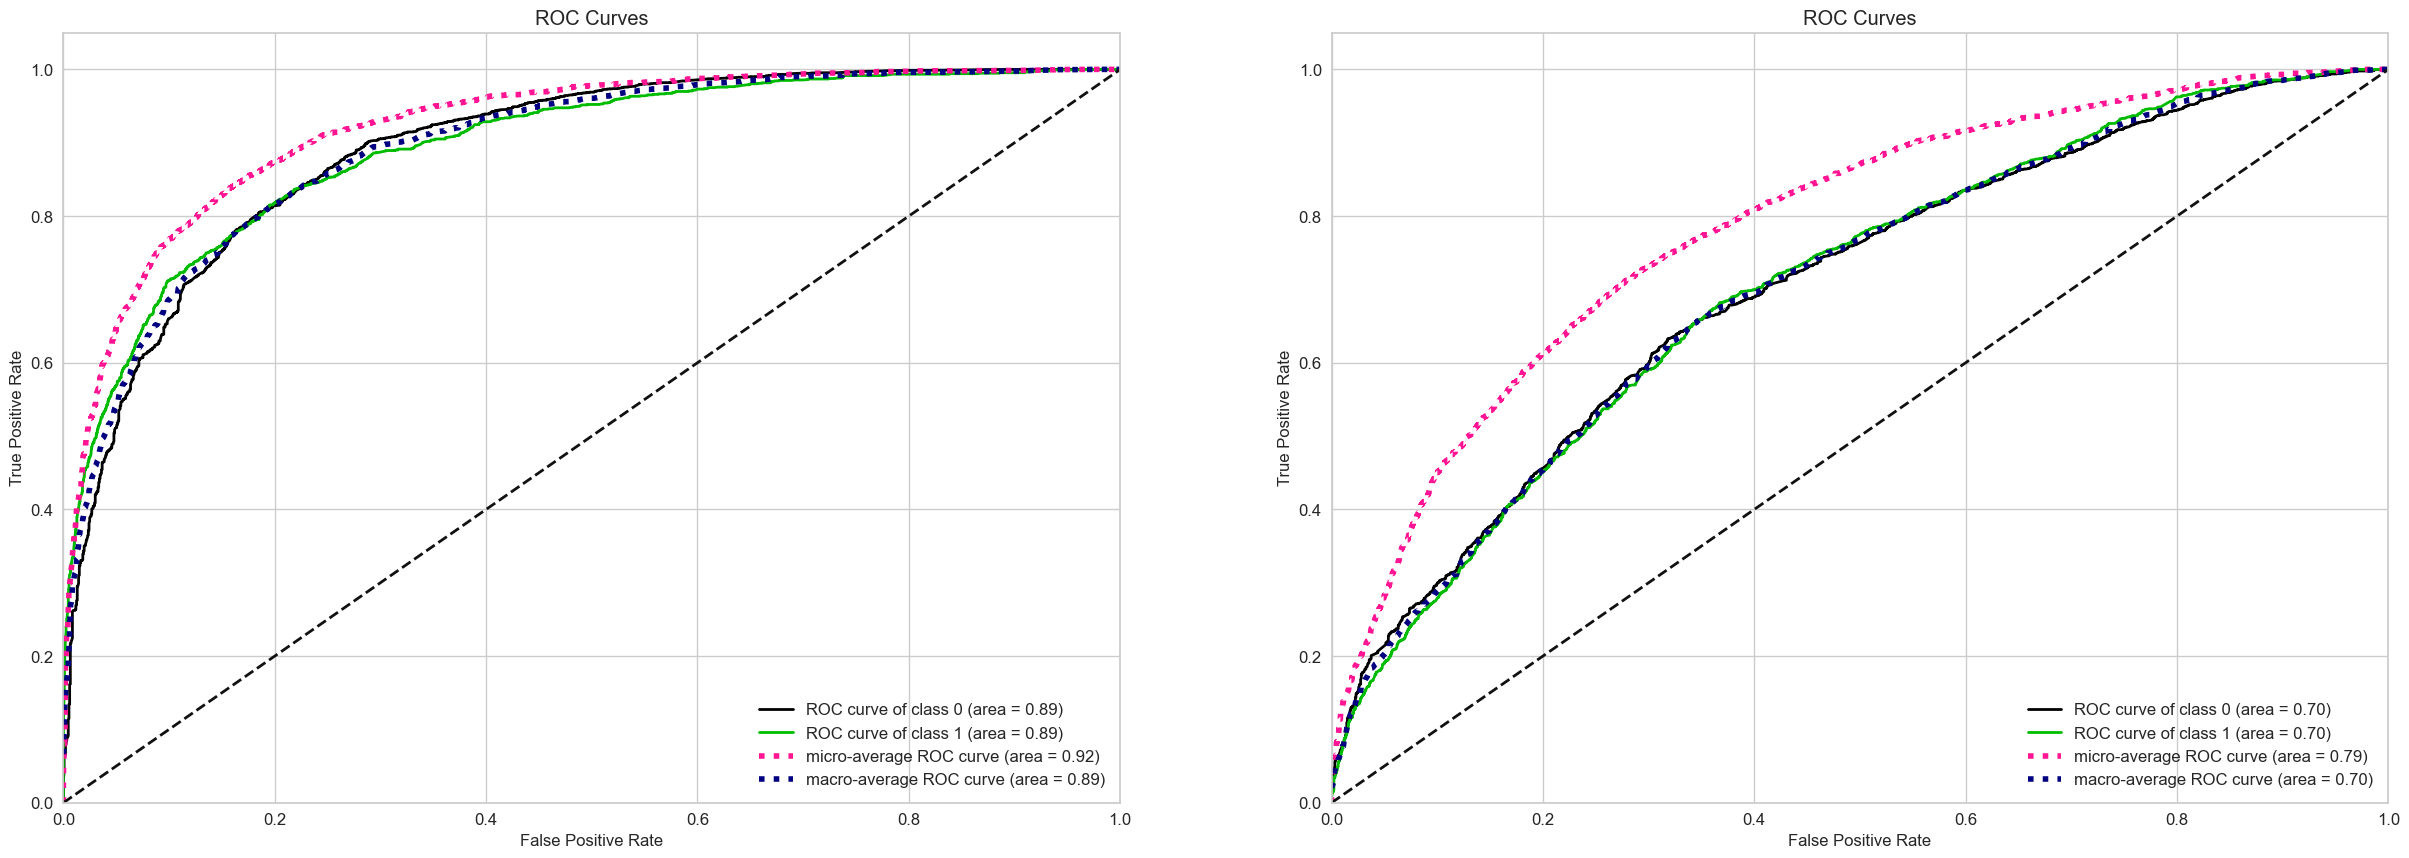

In [18]:
#model
xgbc = XGBClassifier( n_estimators=5, random_state=42, objective='binary:logistic').fit( Xtrain6, ytrain )

fig, axs  = plt.subplots( 1, 2, figsize=(30, 10))

ypred_proba = xgbc.predict_proba( Xtrain6 )
skplt.metrics.plot_roc_curve( ytrain, ypred_proba, ax = axs[0])

ypred_proba = xgbc.predict_proba( Xtest6 )
skplt.metrics.plot_roc_curve( ytest, ypred_proba, ax = axs[1])

## 7.3 LGBM

<AxesSubplot: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

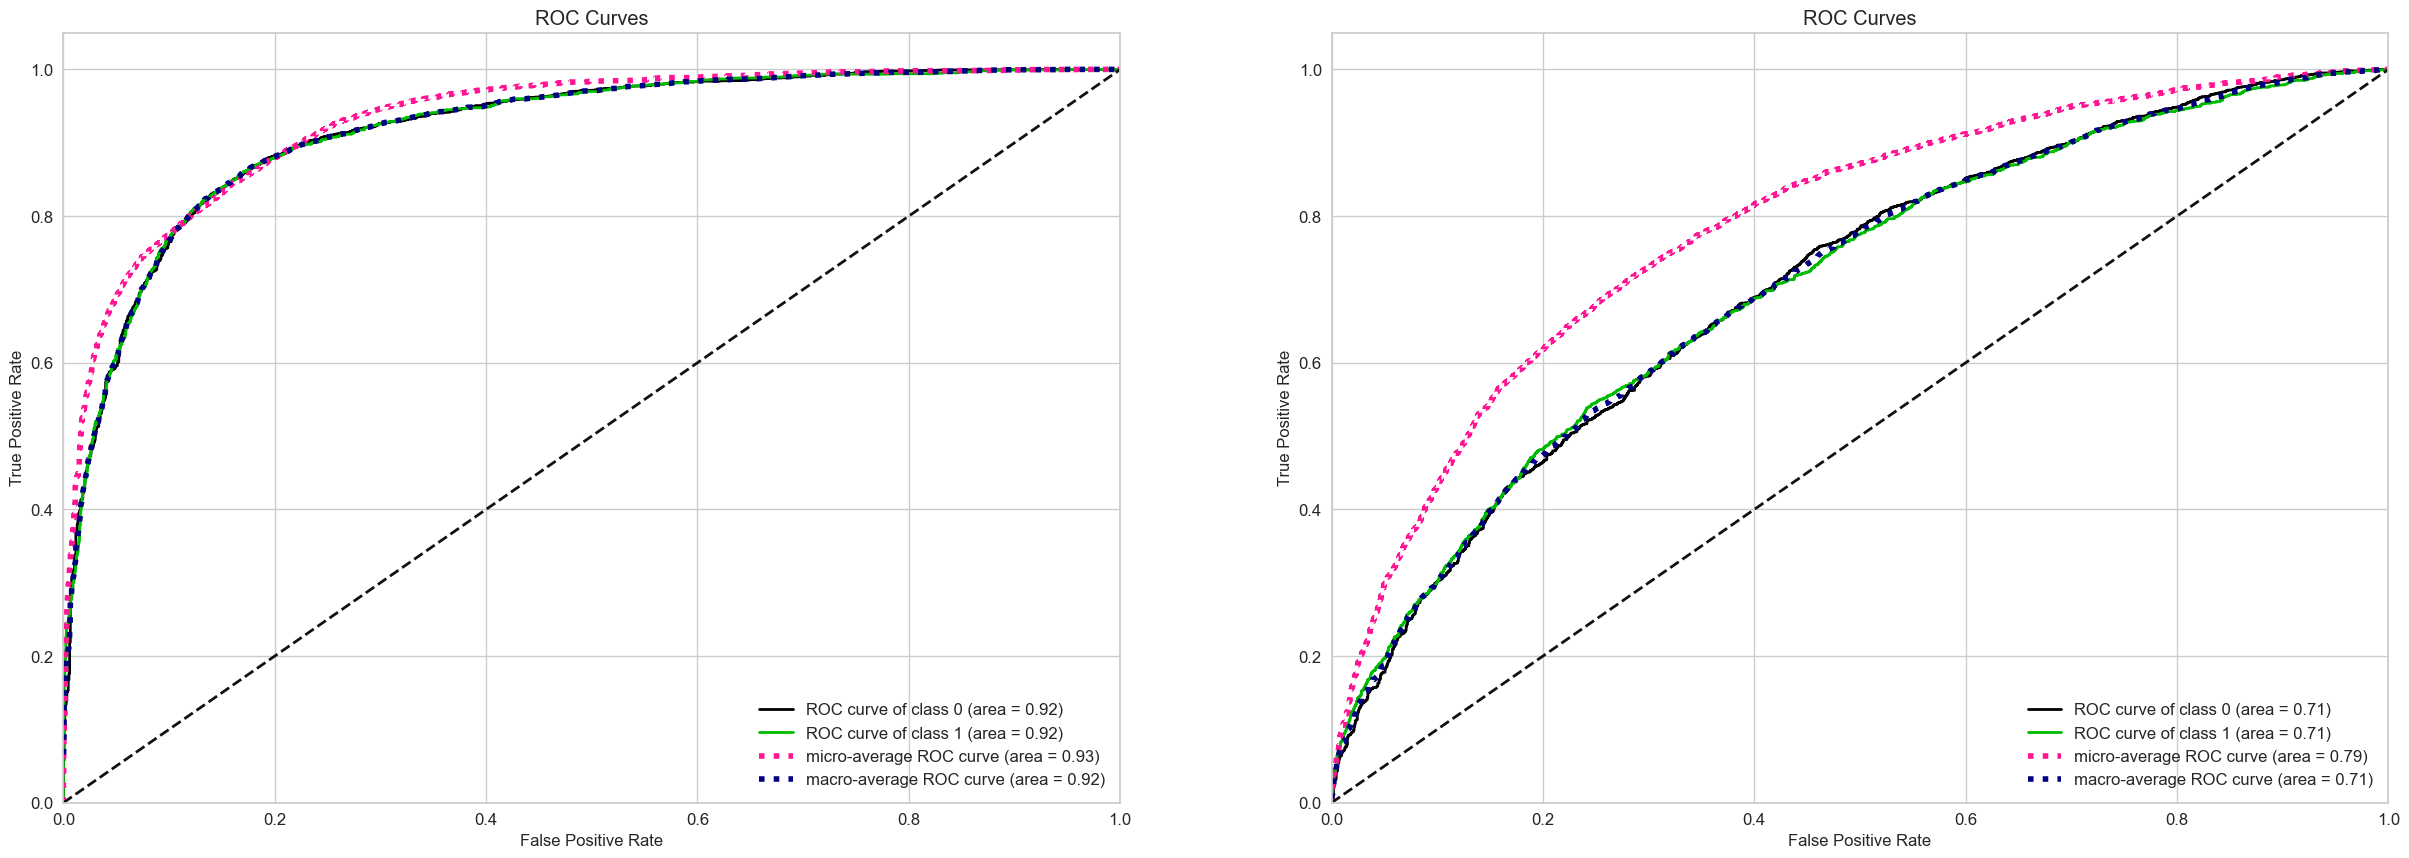

In [19]:
#model
xgbc = LGBMClassifier( n_estimators=20, random_state=42).fit( Xtrain6, ytrain )

fig, axs  = plt.subplots( 1, 2, figsize=(30, 10))

ypred_proba = xgbc.predict_proba( Xtrain6 )
skplt.metrics.plot_roc_curve( ytrain, ypred_proba, ax = axs[0])

ypred_proba = xgbc.predict_proba( Xtest6 )
skplt.metrics.plot_roc_curve( ytest, ypred_proba, ax = axs[1])

## 7.4 LazyClassifier - Various Models

In [20]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None, random_state=42)
models,predictions = clf.fit(Xtrain6, Xtest6, ytrain, ytest)
print(models)

100%|██████████| 29/29 [00:30<00:00,  1.06s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
GaussianNB                         0.63               0.63     0.63      0.65   
NearestCentroid                    0.71               0.60     0.60      0.69   
QuadraticDiscriminantAnalysis      0.65               0.60     0.60      0.65   
BernoulliNB                        0.71               0.57     0.57      0.66   
Perceptron                         0.71               0.56     0.56      0.66   
XGBClassifier                      0.72               0.55     0.55      0.64   
LinearDiscriminantAnalysis         0.72               0.55     0.55      0.64   
DecisionTreeClassifier             0.65               0.55     0.55      0.63   
LogisticRegression                 0.72               0.55     0.55      0.64   
AdaBoostClassifier                 0.71               0.55     0.55      0.64   
CalibratedClassifierCV      

## 7.5 RandomForestClassifier

In [21]:
clf.models['RandomForestClassifier']['classifier'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [22]:
pipe_rf['classifier']

NameError: name 'pipe_rf' is not defined

In [ ]:
pipe_rf.named_steps

{'preprocessor': ColumnTransformer(transformers=[('numeric',
                                  Pipeline(steps=[('imputer', SimpleImputer()),
                                                  ('scaler', StandardScaler())]),
                                  Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
             17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
            dtype='int64')),
                                 ('categorical_low',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(fill_value='missing',
                                                                 strategy='constant')),
                                                  ('encoding',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse=False))]),
                                  Int64Index([], dtype

<AxesSubplot: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

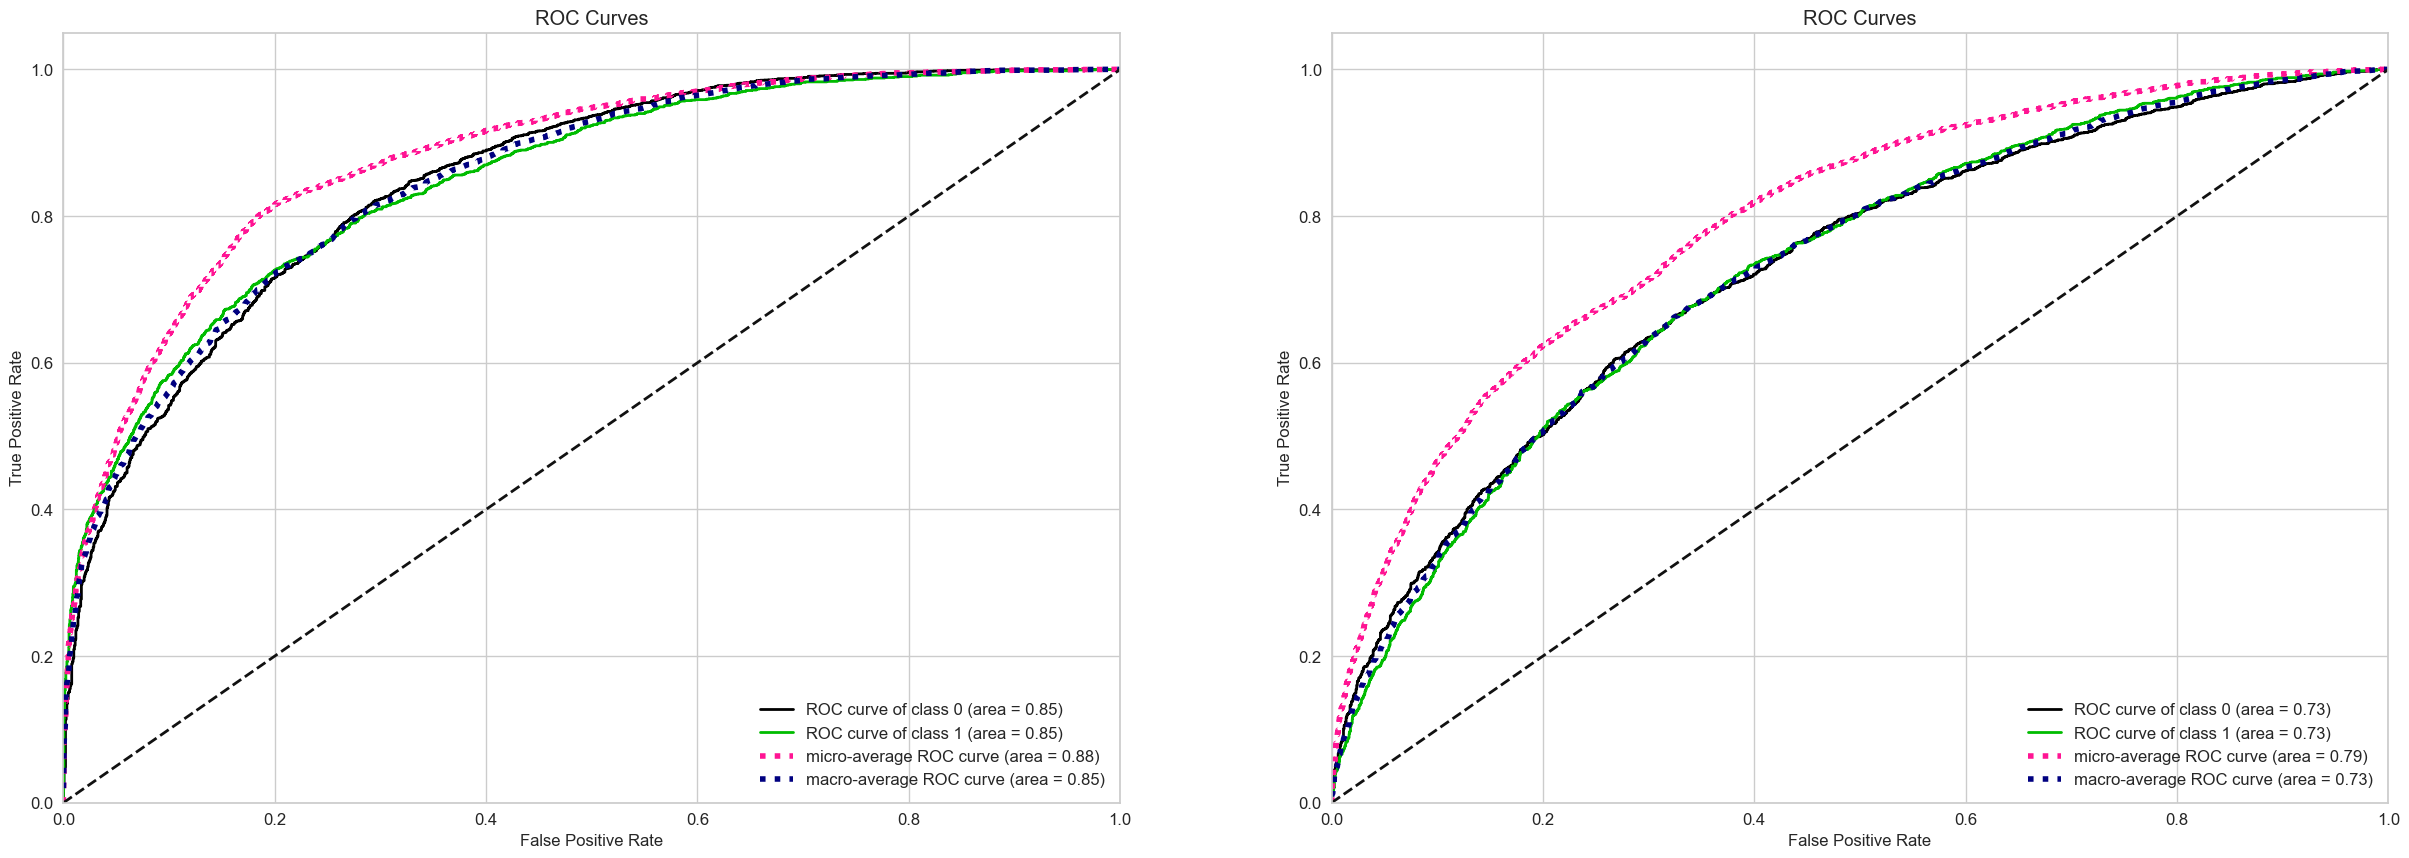

In [ ]:
pipe_rf = clf.models['RandomForestClassifier']

Xtrain6_prep = pipe_rf['preprocessor'].transform(Xtrain6)
Xtest6_prep = pipe_rf['preprocessor'].transform(Xtest6)

rf = RandomForestClassifier(n_estimators=500 , max_depth=5 , random_state=42)
rf.fit(Xtrain6_prep, ytrain)

fig, axs  = plt.subplots( 1, 2, figsize=(30, 10))

ypred_proba = rf.predict_proba( Xtrain6_prep )
skplt.metrics.plot_roc_curve( ytrain, ypred_proba, ax = axs[0])

ypred_proba = rf.predict_proba( Xtest6_prep )
skplt.metrics.plot_roc_curve( ytest, ypred_proba, ax = axs[1])

# 9.0 BUSINESS IMPACT ESTIMATION

# 10.0 DEPLOY TO PRODUCTION